In [3]:
#importamos las librerías generales a utilizar
import networkx as nx 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


#creamos función para abrir .txt
def abrir_txt(nombre_archivo):
    archivo=open(nombre_archivo)
    data=[]
    for linea in archivo:
        linea=linea.strip()
        columna=linea.split()
        data.append(columna)
    return data


### Inciso(a)

In [38]:
redes = {'Y2H': './data/yeast_Y2H.txt', 
         'Papers': './data/netscience_edgelist.txt',
         'Sistema Electrico': './data_01/power_enlaces.txt',
         'Internet': './data/as-22july06_edgelist.txt'
         }

def info_red(red):
    lista_de_enlaces = abrir_txt(red)
    Red = nx.Graph()
    Red.add_edges_from(lista_de_enlaces)
    Grafo = Red
    Grados = Red.degree()
    return Grafo,Grados

def distribucion_grado_normal(red):
    Grafo,Grados = info_red(red)
    lista_grados= [val for (node, val) in Grados]
    hist,binedges = np.histogram(lista_grados,density=True,bins=max(lista_grados))
    bincenters = np.mean(np.vstack([binedges[0:-1],binedges[1:]]), axis=0)
    Hist = np.array((bincenters,hist)).T
    Hist = np.array([i for i in Hist if i[1]*1 != 0.0]).T #me saco de encima los grados con P_{k} = 0
    
    return Hist[0],Hist[1]
    
def cumulative_binning(red):
    Grafo,Grados = info_red(red)
    lista_grados= np.flip(np.sort(([val for (node, val) in Grados])))
    ranking = np.arange(1,len(lista_grados)+1)
    pk = ranking/len(ranking)                  
    return lista_grados,pk
    
def log_binning(red):
    Grafo,Grados = info_red(red)
    lista_grados= [val for (node, val) in Grados]
    espaciado_log = np.logspace(0, 4, num=15, endpoint=True, base=10)
    hist,binedges = np.histogram(lista_grados,espaciado_log,density=True)
    bincenters = np.mean(np.vstack([binedges[0:-1],binedges[1:]]), axis=0)
    
    return hist,bincenters
    
     

0 ./data/yeast_Y2H.txt
1 ./data/netscience_edgelist.txt
2 ./data_01/power_enlaces.txt
3 ./data/as-22july06_edgelist.txt


NetworkXError: Edge tuple ['ABRAMSON,', 'G;KUPERMAN,', "M;{'value':", '2.5}'] must be a 2-tuple or 3-tuple.

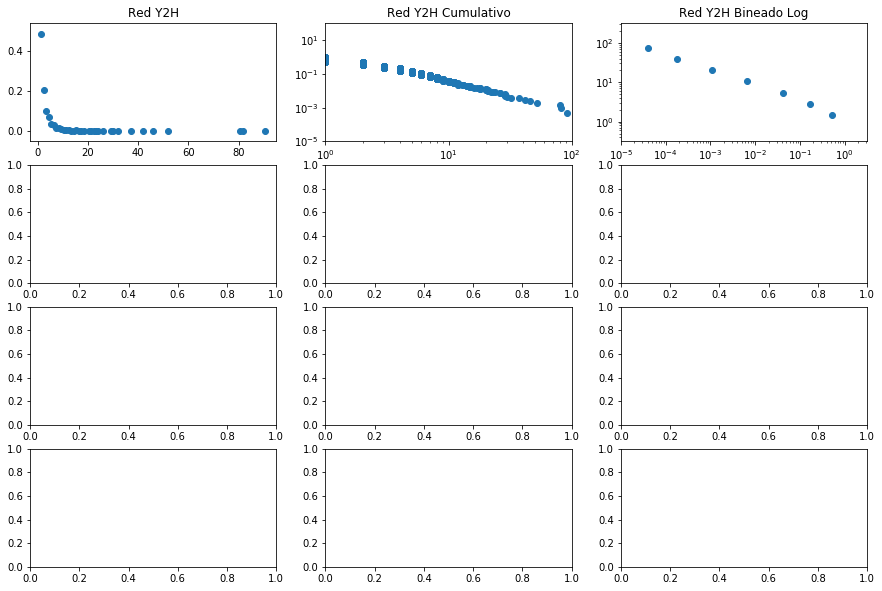

In [39]:
fig, axes = plt.subplots( nrows=4,ncols=3, figsize=(15, 10))

for i, red in enumerate(redes.keys()):
    print(i,redes[red])

for i, red in enumerate(redes.keys()):
    #plot distribucion regular
    x1,y1 = distribucion_grado_normal(redes[red])
    axes[i,0].scatter(x1,y1)
    axes[i,0].set_title(f"Red {red}")
        
    #plot distribucion cumulativa
    x2,y2 = cumulative_binning(redes[red])
    axes[i,1].scatter(x2,y2)
    axes[i,1].set_title(f"Red {red} Cumulativo")
    axes[i,1].set_yscale("log")
    axes[i,1].set_xscale("log")
    axes[i,1].set_xlim(10**0,10**2)
    axes[i,1].set_ylim(10**-5,10**2)
        
    #plot bineado logaritmico
    x3,y3 = log_binning(redes[red])
    axes[i,2].scatter(x3,y3)
    axes[i,2].set_title(f"Red {red} Bineado Log")
    axes[i,2].set_yscale("log")
    axes[i,2].set_xscale("log")
    axes[i,2].set_xlim(10**-5,10**0.5)
    axes[i,2].set_ylim(10**-0.5,10**2.5)
        



### Inciso(b)
Discuta cuál o cuáles casos se ajustan mejor a una ‘power law’, donde la probabilidad de
que un nodo tenga un dado grado k está dada por la ecuación: Pk = Ck−γ


### Inciso(c)
Diga si encuentra algún efecto de borde dado por el tamaño finito de las redes, y para cuáles
redes es más o menos apreciable

Ajusto para ver si se cumplen las leyes de potencia para cada red:
$p(k) = Ck^{-\gamma}$.
Con el bineado logaritmico me queda:
$C = (\gamma - 1) K_{min}^{(\gamma-1)}$. Con $K_{min} = $
$ L(k|\gamma) = 𝑝(𝑘)
yada yada

In [37]:
def gamma(N,k,kmin):
    return 1 + N * 1/(np.sum(np.log(k/(kmin-0.5))))

def L(N,k,kmin):
    return np.prod(((gamma(N,k,kmin)-1)/kmin)*((k/kmin)**(-gamma(N,k,kmin))))

hist,bins = cumulative_binning('./data/as-22july06_edgelist.txt')
print(L(2018,bins,3),gamma(2018,bins,3))


ValueError: dictionary update sequence element #0 has length 1; 2 is required

In [ ]:


fig, axes = plt.subplots( nrows=2,ncols=2, figsize=(15, 10))

escala = ["linear","log"]
limites_plot = [[(-100,2800),(-0.2,1)],[(10**0,10**4),(10**(-5),10**0)]]

for i in range(2):
    for j in range(2):
        axes[i,j].scatter(data[0],data[1])
        axes[i,j].set_yscale(escala[i])
        axes[i,j].set_xscale(escala[j])
        axes[i,j].set_xlim(limites_plot[j][0])
        axes[i,j].set_ylim(limites_plot[i][1])
        axes[i,j].set_title("Escala en x: " + escala[j] + ". Escala en y:" + escala[i])
        axes[i,j].set_ylabel('P_{k}')
        axes[i,j].set_xlabel('Grado (k)')
